<a href="https://colab.research.google.com/github/zain-0/Malaria-Diagnosis-using-LeNet-and-WandB.AI/blob/main/Malaria_Diagnosis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import cv2
import seaborn as sns
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping,LearningRateScheduler,TensorBoard
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Resizing, Rescaling, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.regularizers import L2
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy,TruePositives,FalsePositives,TrueNegatives,FalseNegatives,Precision,Recall,AUC
from tensorflow.keras.losses import BinaryCrossentropy
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint,WandbCallback
import random

In [ ]:
dataset, dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])


# Splitting of Data

In [ ]:
def split(datasets, train_ratio, val_ratio, test_ratio):
    dataset_size = len(datasets)

    # Calculate sizes for each split
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = int(test_ratio * dataset_size)

    # Split the dataset directly
    train_dataset = datasets.take(train_size)
    val_test_dataset = datasets.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
Train_ratio = 0.8
Validation_ratio = 0.1
Test_ratio = 0.1
train_dataset, val_dataset, test_dataset = split(dataset[0],Train_ratio,Validation_ratio, Test_ratio)

# Function to check the number of sample in train_dataset.
print(tf.data.experimental.cardinality(test_dataset))

tf.Tensor(2757, shape=(), dtype=int64)


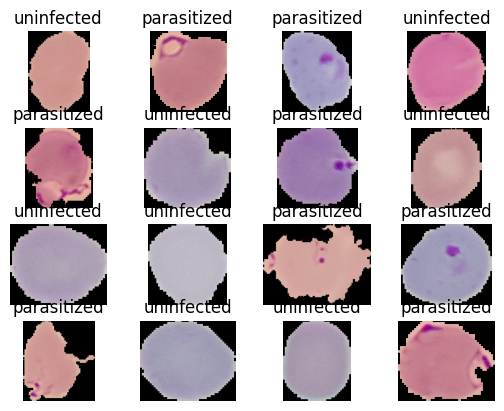

In [ ]:
for example, (image, label) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4,example+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(dataset_info.features['label'].int2str(label))

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

# Data Augmentation

In [ ]:
def visualize_difference(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image,label=next(iter(train_dataset))

In [ ]:
augmented_image=tf.image.adjust_brightness(original_image,-0.5)

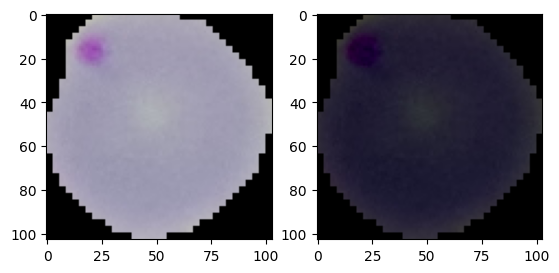

In [ ]:
visualize_difference(original_image,augmented_image)

# Mix-Up Data Augmentation

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing)
train_dataset_2 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing)

mixed_dataset=tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

In [ ]:
def mix_up(image, label):
    alpha = 1.0
    beta = 1.0

    # Create a new dataset with different shuffling
    shuffled_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
    it = iter(shuffled_dataset)

    # Get two batches from the shuffled dataset
    (image_1, label_1) = next(it)
    (image_2, label_2) = next(it)

    # Cast labels to tf.float32
    label_1 = tf.cast(label_1, tf.float32)
    label_2 = tf.cast(label_2, tf.float32)

    # Mix up the images and labels
    mixed_image = alpha * image_1 + (1 - alpha) * image_2
    mixed_label = beta * label_1 + (1 - beta) * label_2

    return mixed_image, mixed_label


In [ ]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(mix_up).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Resizing of Data

In [ ]:
IM_size = 224
def resizing(image,label):
  # Dividing by 255 for normalization.
  return tf.image.resize(image,(IM_size,IM_size))/255, label

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label.numpy())

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) 1


In [ ]:
BATCH_SIZE = 32


train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resizing).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resizing).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Callbacks

In [ ]:
tensorboard_callback = TensorBoard(
    log_dir='logs'
)
LOG_DIR ='/content/logs'

In [ ]:
csv_callback=CSVLogger('logs.csv',separator = ',',append=True)

In [ ]:
es_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,

)

# Model Creation and Training

In [ ]:


IM_size = 224

dropout_rate = 0.3
regularization_rate = 0.01

# Data augmentation layers
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

# Resizing and Rescaling layers
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_size, IM_size),
    Rescaling(1.0 / 255)
])

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layers,
    augment_layers,
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(10, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model.summary()


In [ ]:

metrics = [BinaryAccuracy(name='accuracy'),TruePositives(name='TP'),FalsePositives(name='FP'),TrueNegatives(name='TN'),FalseNegatives(name='FN'),Precision(name='precision'),Recall(name='recall'),AUC(name='AuC')]

In [ ]:

binary_crossentropy_loss = BinaryCrossentropy()

lenet_model.compile(optimizer=Adam(learning_rate=0.01), loss=binary_crossentropy_loss,metrics=metrics)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=6,verbose= 1 ,callbacks = [tensorboard_callback])

Epoch 1/6
689/689 [==============================] - 63s 67ms/step - loss: 3.7644 - accuracy: 0.6385 - TP: 7138.0000 - FP: 4084.0000 - TN: 6938.0000 - FN: 3886.0000 - precision: 0.6361 - recall: 0.6475 - AuC: 0.6839 - val_loss: 2.6724 - val_accuracy: 0.5034 - val_TP: 1387.0000 - val_FP: 1368.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_precision: 0.5034 - val_recall: 1.0000 - val_AuC: 0.6900
Epoch 2/6
689/689 [==============================] - 61s 88ms/step - loss: 3.0594 - accuracy: 0.6603 - TP: 7492.0000 - FP: 3955.0000 - TN: 7066.0000 - FN: 3533.0000 - precision: 0.6545 - recall: 0.6795 - AuC: 0.7103 - val_loss: 13.1948 - val_accuracy: 0.5053 - val_TP: 1392.0000 - val_FP: 1363.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_precision: 0.5053 - val_recall: 1.0000 - val_AuC: 0.5004
Epoch 3/6
689/689 [==============================] - 44s 63ms/step - loss: 2.2311 - accuracy: 0.8297 - TP: 9532.0000 - FP: 2263.0000 - TN: 8760.0000 - FN: 1491.0000 - precision: 0.8081 - recall

In [ ]:
lenet_model.save_weights('weights_5.h5')

# TensorBoard

In [ ]:
%reload_ext tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="logs"

# Hyperparameter Tuning using TensorBoard

In [ ]:
IM_SIZE = 224

# Data augmentation layers
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

# Resizing and Rescaling layers
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_size, IM_size),
    Rescaling(1.0 / 255)
])
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),

    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy



In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,

          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1


# Model Evaluation

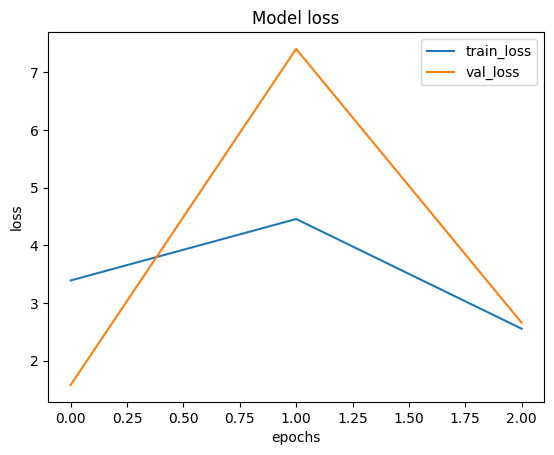

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'])
plt.show()

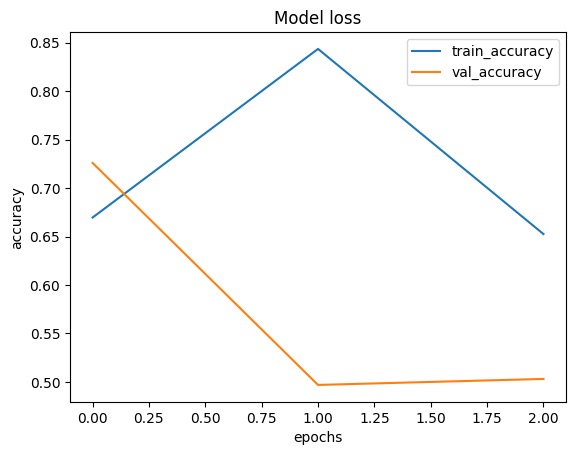

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [ ]:
test_dataset=test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 25s 5ms/step - loss: 2.6462 - accuracy: 0.5125 - TP: 48.0000 - FP: 28.0000 - TN: 1365.0000 - FN: 1316.0000 - precision: 0.6316 - recall: 0.0352 - AuC: 0.6900


[2.6462223529815674,
 0.5125135779380798,
 48.0,
 28.0,
 1365.0,
 1316.0,
 0.6315789222717285,
 0.03519061580300331,
 0.6900400519371033]

In [ ]:
image=cv2.imread('cell.png')
print(image.shape)
image=tf.expand_dims(image,axis=0)
print(image.shape)

parasite_or_not(lenet_model.predict(image))

(210, 212, 3)
(1, 210, 212, 3)
1/1 [==============================] - 0s 17ms/step


'Parasite'

# Threshold Experimenting

In [ ]:
from sklearn.metrics import confusion_matrix,roc_curve
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
labels = np.array(i[0] for i in labels)

In [ ]:
predicted=lenet_model.predict(np.array(inp)[:,0,...])

87/87 [==============================] - 1s 13ms/step


In [ ]:
predicted=predicted[:,0]

Text(0.5, 58.7222222222222, 'Predicted')

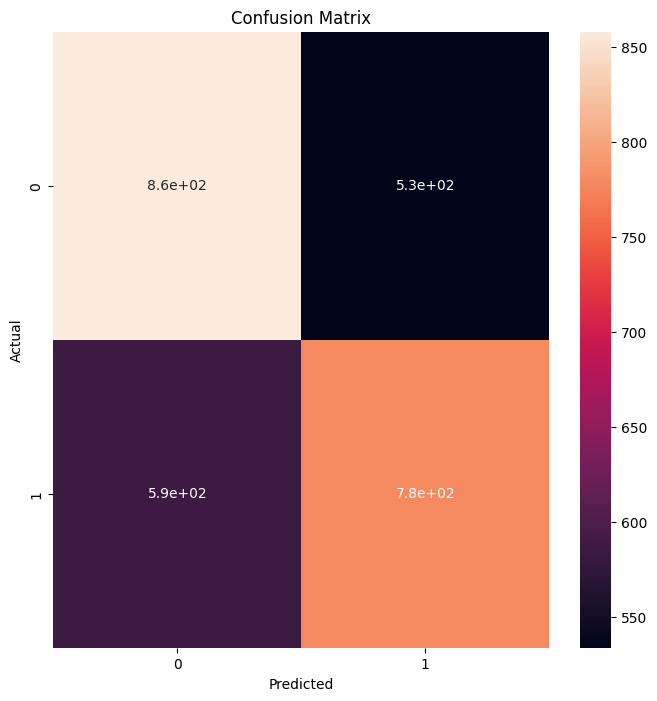

In [ ]:
CM=confusion_matrix(labels,predicted>0.52)
plt.figure(figsize=(8,8))
sns.heatmap(CM,annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

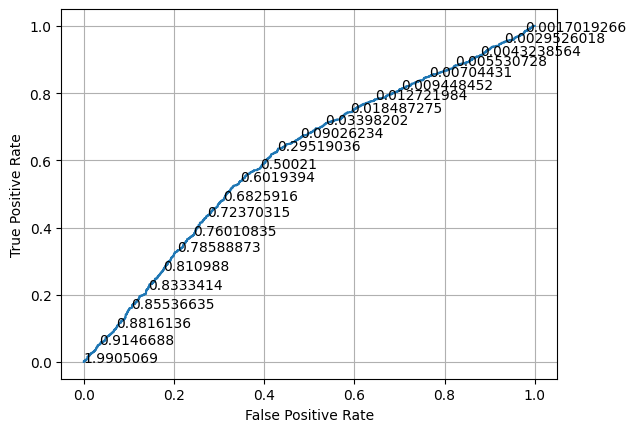

In [ ]:
fp,tp,threshold = roc_curve(labels,predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

skip = 60

for i in range(0,len(threshold),skip):
  plt.text(fp[i],tp[i],threshold[i])
plt.show()

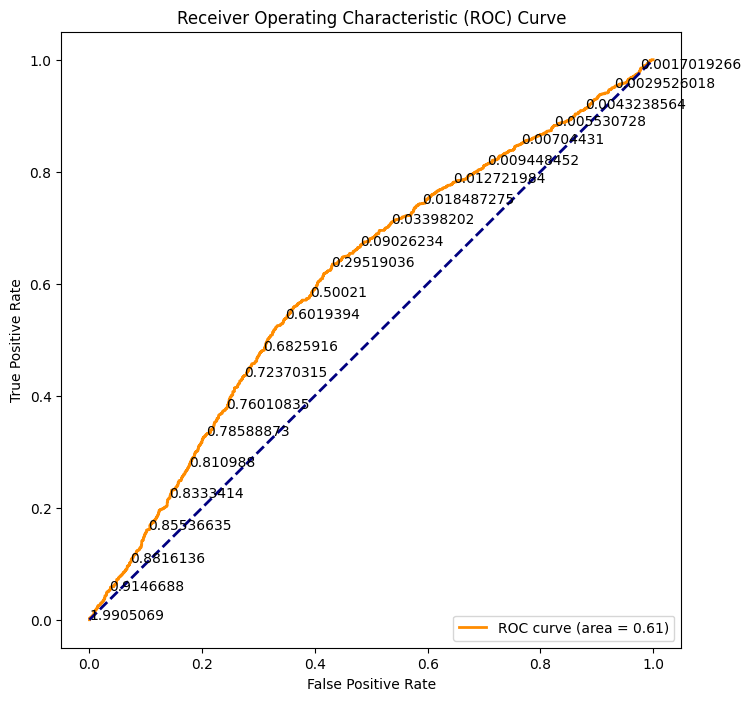

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming labels and predicted are your true labels and predicted scores
fpr, tpr, thresholds = roc_curve(labels, predicted)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

skip = 60

for i in range(0,len(thresholds),skip):
  plt.text(fp[i],tp[i],thresholds[i])
plt.show()


In [ ]:
def parasite_or_not(x):
  if (x>0.5):
    return str('Uneffected')
  else:
    return str('Parasite')

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 0s 19ms/step


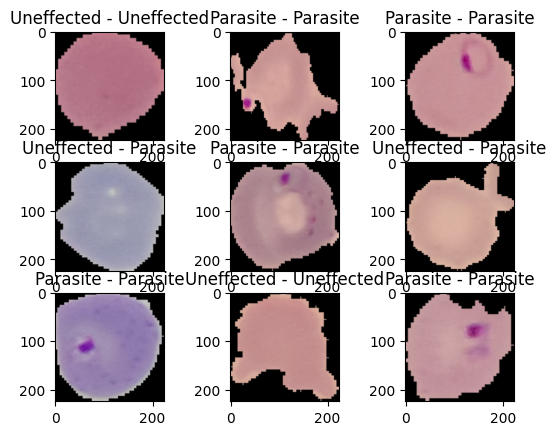

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])+" - "+ str(parasite_or_not(lenet_model.predict(image)[0][0]))))
  plt.axis=('off')

In [ ]:
from google.colab import files

# Download the saved model file
files.download('model_weights.h5')  # Replace with your file name


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Functional API


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
func_input= Input(shape=(IM_size,IM_size,3))

x = Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Flatten()(x)

x = Dense(100,activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1,activation='sigmoid')(x)
lenet_model_func=Model(func_input,func_output,name = 'Lenet Model Functional')
lenet_model_func.summary()

Model: "Lenet Model Functional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_24 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_25 (Ba  (None, 109, 109

# WandB

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: muhammad_zain (practice_0). Use `wandb login --relogin` to force relogin


In [ ]:




# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="Malaria Detection",
)


In [ ]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    BatchNormalization,
    MaxPool2D,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.keras.regularizers import L2
# from wandb.sweeps.config import uniform
import tensorflow as tf

CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 3,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.2,
    'IM_SIZE': 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 6,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32,
}


In [ ]:
sweep_configuration = {
    "name": "Malaria_Diagnosis_Sweep",
    "method": "random",
    "metric": {
        "goal": "maximize",
        "name": "accuracy"
    },
    "parameters": {
        "N_EPOCHS": {
            "values": [3, 5, 8, 10]
        },
        "BATCH_SIZE": {
            "values": [64, 128, 256]
        },
        "IM_SIZE": {
            "values": [224]
        },
        "DROPOUT_RATE": {
            "distribution": "uniform",
            "min": 0.1,
            "max": 0.4
        },
        "LEARNING_RATE": {
            "distribution": "uniform",
            "min": 0.0001,
            "max": 0.1
        },
        "REGULARIZATION_RATE": {
            "values": [0.0, 0.001, 0.01]
        },
        "N_FILTERS": {
            "values": [6, 12, 24]
        },
        "KERNEL_SIZE": {
            "values": [3, 5, 7]
        },
        "N_STRIDES": {
            "values": [1, 2]
        },
        "POOL_SIZE": {
            "values": [2, 4]
        },
        "N_DENSE_1": {
            "values": [64, 128, 256]
        },
        "N_DENSE_2": {
            "values": [32, 64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="Malaria Detection")


Create sweep with ID: jj4ctfpr
Sweep URL: https://wandb.ai/practice_0/Malaria%20Detection/sweeps/jj4ctfpr


In [ ]:
IM_SIZE = 224

# Data augmentation layers
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(0.25, 0.2501)),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomContrast(factor=0.1)
])

# Resizing and Rescaling layers
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(IM_SIZE, IM_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])

def model_tune(config):
    config = wandb.config
    lenet_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(config.IM_SIZE, config.IM_SIZE, 3)),
        tf.keras.layers.Conv2D(filters=config.N_FILTERS, kernel_size=config.KERNEL_SIZE, strides=config.N_STRIDES, padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(config.REGULARIZATION_RATE)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=config.POOL_SIZE, strides=config.N_STRIDES),
        tf.keras.layers.Dropout(rate=config.DROPOUT_RATE),

        tf.keras.layers.Conv2D(filters=config.N_FILTERS, kernel_size=config.KERNEL_SIZE, strides=config.N_STRIDES, padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(config.REGULARIZATION_RATE)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=config.POOL_SIZE, strides=config.N_STRIDES),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(config.N_DENSE_1, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(config.REGULARIZATION_RATE)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=config.DROPOUT_RATE),

        tf.keras.layers.Dense(config.N_DENSE_2, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(config.REGULARIZATION_RATE)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    return lenet_model




In [ ]:
def train():
    with wandb.init(project="Malaria Detection", config=sweep_configuration) as run:
        config = wandb.config
        model = model_tune(config)
        model = model_tune(config)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy'],
        )

        model.fit(val_dataset, epochs=config.N_EPOCHS, callbacks=WandbCallback())

wandb.agent(sweep_id, function=train, count=5)

wandb: Agent Starting Run: qbbjhfic with config:
wandb: 	BATCH_SIZE: 128
wandb: 	DROPOUT_RATE: 0.20486024821790844
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 5
wandb: 	LEARNING_RATE: 0.06746372118563575
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 3
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 4
wandb: 	REGULARIZATION_RATE: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/3
 6/87 [=>............................] - ETA: 6s - loss: 465.3846 - accuracy: 0.5677

87/87 [==============================] - 22s 80ms/step - loss: 366.6527 - accuracy: 0.5492
Epoch 2/3
87/87 [==============================] - 18s 83ms/step - loss: 17.3987 - accuracy: 0.5706
Epoch 3/3
87/87 [==============================] - 18s 79ms/step - loss: 13.0489 - accuracy: 0.5710


accuracy,▁██
epoch,▁▅█
loss,█▁▁
accuracy,0.57096
epoch,2
loss,13.04889


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ab94627a with config:
wandb: 	BATCH_SIZE: 64
wandb: 	DROPOUT_RATE: 0.21660951318477348
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 7
wandb: 	LEARNING_RATE: 0.07883990714024308
wandb: 	N_DENSE_1: 256
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 8
wandb: 	N_FILTERS: 24
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 4
wandb: 	REGULARIZATION_RATE: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/8
 6/87 [=>............................] - ETA: 18s - loss: 20554.0078 - accuracy: 0.5521

87/87 [==============================] - 39s 238ms/step - loss: 3752.8518 - accuracy: 0.5604
Epoch 2/8
87/87 [==============================] - 31s 232ms/step - loss: 29.4482 - accuracy: 0.5568
Epoch 3/8
87/87 [==============================] - 31s 233ms/step - loss: 73.8468 - accuracy: 0.5405
Epoch 4/8
87/87 [==============================] - 31s 234ms/step - loss: 16.5678 - accuracy: 0.5445
Epoch 5/8
87/87 [==============================] - 30s 234ms/step - loss: 25.0538 - accuracy: 0.5485
Epoch 6/8
87/87 [==============================] - 31s 233ms/step - loss: 159.1632 - accuracy: 0.5249
Epoch 7/8
87/87 [==============================] - 31s 234ms/step - loss: 61.9426 - accuracy: 0.5241
Epoch 8/8
87/87 [==============================] - 30s 234ms/step - loss: 31.6607 - accuracy: 0.5263


accuracy,█▇▄▅▆▁▁▁
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
accuracy,0.52632
epoch,7
loss,31.66067


wandb: Agent Starting Run: 5wpxmvzu with config:
wandb: 	BATCH_SIZE: 64
wandb: 	DROPOUT_RATE: 0.3156792584945858
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 5
wandb: 	LEARNING_RATE: 0.04575156105066433
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 10
wandb: 	N_FILTERS: 24
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
 6/87 [=>............................] - ETA: 13s - loss: 1022.7150 - accuracy: 0.6406

87/87 [==============================] - 39s 170ms/step - loss: 1047.5298 - accuracy: 0.5975
Epoch 2/10
87/87 [==============================] - 25s 166ms/step - loss: 19.1808 - accuracy: 0.6149
Epoch 3/10
87/87 [==============================] - 23s 166ms/step - loss: 24.9419 - accuracy: 0.5906
Epoch 4/10
87/87 [==============================] - 25s 165ms/step - loss: 32.6755 - accuracy: 0.5848
Epoch 5/10
87/87 [==============================] - 25s 165ms/step - loss: 5.0782 - accuracy: 0.5942
Epoch 6/10
87/87 [==============================] - 25s 166ms/step - loss: 30.7775 - accuracy: 0.5855
Epoch 7/10
87/87 [==============================] - 25s 165ms/step - loss: 11.1738 - accuracy: 0.6080
Epoch 8/10
87/87 [==============================] - 25s 166ms/step - loss: 4.7266 - accuracy: 0.5920
Epoch 9/10
87/87 [==============================] - 25s 166ms/step - loss: 41.4542 - accuracy: 0.5797
Epoch 10/10
87/87 [==============================] - 23s 165ms/step - loss: 32.2627 - accurac

accuracy,▆█▆▅▆▅▇▆▅▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
accuracy,0.53358
epoch,9
loss,32.26266


wandb: Agent Starting Run: 9n2db9ox with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DROPOUT_RATE: 0.18449431799944024
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 5
wandb: 	LEARNING_RATE: 0.009055932017320386
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 32
wandb: 	N_EPOCHS: 10
wandb: 	N_FILTERS: 24
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
 6/87 [=>............................] - ETA: 13s - loss: 45.7009 - accuracy: 0.5677

87/87 [==============================] - 28s 167ms/step - loss: 141.6331 - accuracy: 0.5822
Epoch 2/10
87/87 [==============================] - 25s 166ms/step - loss: 34.0728 - accuracy: 0.6312
Epoch 3/10
87/87 [==============================] - 25s 166ms/step - loss: 13.1954 - accuracy: 0.6196
Epoch 4/10
87/87 [==============================] - 25s 165ms/step - loss: 4.3210 - accuracy: 0.6359
Epoch 5/10
87/87 [==============================] - 25s 167ms/step - loss: 2.8144 - accuracy: 0.6381
Epoch 6/10
87/87 [==============================] - 33s 166ms/step - loss: 12.3217 - accuracy: 0.6265
Epoch 7/10
87/87 [==============================] - 24s 166ms/step - loss: 7.1445 - accuracy: 0.6374
Epoch 8/10
87/87 [==============================] - 25s 167ms/step - loss: 5.5707 - accuracy: 0.6367
Epoch 9/10
87/87 [==============================] - 25s 165ms/step - loss: 2.1907 - accuracy: 0.6338
Epoch 10/10
87/87 [==============================] - 25s 165ms/step - loss: 2.0632 - accuracy: 0.

accuracy,▁▇▆██▇██▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▂▁▁▁▁
accuracy,0.62904
epoch,9
loss,2.06324


wandb: Agent Starting Run: pau4lyc7 with config:
wandb: 	BATCH_SIZE: 256
wandb: 	DROPOUT_RATE: 0.25895414039041253
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0442422695891516
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 32
wandb: 	N_EPOCHS: 10
wandb: 	N_FILTERS: 24
wandb: 	N_STRIDES: 2
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
87/87 [==============================] - 18s 55ms/step - loss: 5.7481 - accuracy: 0.5681
Epoch 2/10
87/87 [==============================] - 14s 37ms/step - loss: 2.2991 - accuracy: 0.5699
Epoch 3/10
87/87 [==============================] - 14s 37ms/step - loss: 1.8976 - accuracy: 0.5844
Epoch 4/10
87/87 [==============================] - 14s 40ms/step - loss: 2.5989 - accuracy: 0.5746
Epoch 5/10
87/87 [==============================] - 14s 37ms/step - loss: 1.7078 - accuracy: 0.5568
Epoch 6/10
87/87 [==============================] - 14s 36ms/step - loss: 2.6570 - accuracy: 0.5844
Epoch 7/10
87/87 [==============================] - 14s 35ms/step - loss: 2.1478 - accuracy: 0.6062
Epoch 8/10
87/87 [==============================] - 14s 36ms/step - loss: 2.1774 - accuracy: 0.5819
Epoch 9/10
87/87 [==============================] - 14s 37ms/step - loss: 1.7652 - accuracy: 0.5887
Epoch 10/10
87/87 [==============================] - 14s 36ms/step - loss: 1.8708 - accuracy: 0.5746

accuracy,▃▃▅▄▁▅█▅▆▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▃▁▃▂▂▁▁
accuracy,0.57459
epoch,9
loss,1.87078


# Simple Run With WandB

In [ ]:


IM_size = CONFIGURATION['IM_SIZE']
DROPOUT = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
LEARNING_RATE = CONFIGURATION['LEARNING_RATE']







# Data augmentation layers
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

# Resizing and Rescaling layers
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_size, IM_size),
    Rescaling(1.0 / 255)
])

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layers,
    augment_layers,
    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2),
    Dropout(rate=DROPOUT),

    Conv2D(filters=N_FILTERS*2 + 4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer=L2(REGULARIZATION)),
    BatchNormalization(),
    Dropout(rate=DROPOUT),

    Dense(10, activation='relu', kernel_regularizer=L2(REGULARIZATION)),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 219, 219, 6)       654       
                                                                 
 batch_normalization_16 (Ba  (None, 219, 219, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 109, 109, 6)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 109, 109, 6)     

In [ ]:

metrics = [BinaryAccuracy(name='accuracy'),TruePositives(name='TP'),FalsePositives(name='FP'),TrueNegatives(name='TN'),FalseNegatives(name='FN'),Precision(name='precision'),Recall(name='recall'),AUC(name='AuC')]

In [ ]:

binary_crossentropy_loss = BinaryCrossentropy()

lenet_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=binary_crossentropy_loss,metrics=metrics)

In [ ]:
history=lenet_model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=CONFIGURATION['N_EPOCHS'],
                        verbose= 1 ,
                        callbacks = [WandbCallback()])

Epoch 1/3
  6/689 [..............................] - ETA: 41s - loss: 0.7931 - accuracy: 0.5573 - TP: 53.0000 - FP: 43.0000 - TN: 54.0000 - FN: 42.0000 - precision: 0.5521 - recall: 0.5579 - AuC: 0.5843

688/689 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.7973 - TP: 8919.0000 - FP: 2373.0000 - TN: 8635.0000 - FN: 2089.0000 - precision: 0.7899 - recall: 0.8102 - AuC: 0.8773

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240131_223007-pyewozm9/files/model-best)... Done. 0.2s


689/689 [==============================] - 63s 85ms/step - loss: 0.4402 - accuracy: 0.7975 - TP: 8932.0000 - FP: 2374.0000 - TN: 8650.0000 - FN: 2090.0000 - precision: 0.7900 - recall: 0.8104 - AuC: 0.8775 - val_loss: 1.3602 - val_accuracy: 0.5053 - val_TP: 1391.0000 - val_FP: 1362.0000 - val_TN: 1.0000 - val_FN: 1.0000 - val_precision: 0.5053 - val_recall: 0.9993 - val_AuC: 0.6795
Epoch 2/3
688/689 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9208 - TP: 10311.0000 - FP: 1045.0000 - TN: 9961.0000 - FN: 699.0000 - precision: 0.9080 - recall: 0.9365 - AuC: 0.9616

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240131_223007-pyewozm9/files/model-best)... Done. 0.2s


689/689 [==============================] - 58s 84ms/step - loss: 0.2302 - accuracy: 0.9207 - TP: 10326.0000 - FP: 1047.0000 - TN: 9972.0000 - FN: 701.0000 - precision: 0.9079 - recall: 0.9364 - AuC: 0.9615 - val_loss: 0.2543 - val_accuracy: 0.9085 - val_TP: 1345.0000 - val_FP: 209.0000 - val_TN: 1158.0000 - val_FN: 43.0000 - val_precision: 0.8655 - val_recall: 0.9690 - val_AuC: 0.9695
Epoch 3/3
688/689 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9355 - TP: 10441.0000 - FP: 849.0000 - TN: 10155.0000 - FN: 571.0000 - precision: 0.9248 - recall: 0.9481 - AuC: 0.9677

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240131_223007-pyewozm9/files/model-best)... Done. 0.2s


689/689 [==============================] - 79s 114ms/step - loss: 0.2001 - accuracy: 0.9355 - TP: 10454.0000 - FP: 850.0000 - TN: 10171.0000 - FN: 571.0000 - precision: 0.9248 - recall: 0.9482 - AuC: 0.9677 - val_loss: 0.2114 - val_accuracy: 0.9325 - val_TP: 1345.0000 - val_FP: 144.0000 - val_TN: 1224.0000 - val_FN: 42.0000 - val_precision: 0.9033 - val_recall: 0.9697 - val_AuC: 0.9725


In [ ]:
wandb.finish

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

In [ ]:
BATCH_SIZE = 32

train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .map(resizing)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(resizing)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
